In [24]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [25]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [26]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [27]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [28]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [29]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [30]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    dQs = tf.reshape(dQs, shape=[-1])
    aloss2 += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [31]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [32]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [33]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [34]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [35]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [36]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [37]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [38]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 aloss:1.4243 dloss:2.0892 aloss2:0.5882 exploreP:0.9982
Episode:1 meanR:22.0000 R:26.0000 rate:0.0520 aloss:1.4224 dloss:2.0484 aloss2:0.6065 exploreP:0.9957
Episode:2 meanR:18.3333 R:11.0000 rate:0.0220 aloss:1.4077 dloss:1.9784 aloss2:0.6282 exploreP:0.9946
Episode:3 meanR:17.0000 R:13.0000 rate:0.0260 aloss:1.4285 dloss:2.0754 aloss2:0.6320 exploreP:0.9933
Episode:4 meanR:16.2000 R:13.0000 rate:0.0260 aloss:1.3993 dloss:1.8920 aloss2:0.6516 exploreP:0.9920
Episode:5 meanR:16.0000 R:15.0000 rate:0.0300 aloss:1.4105 dloss:1.9346 aloss2:0.6375 exploreP:0.9905
Episode:6 meanR:15.4286 R:12.0000 rate:0.0240 aloss:1.4065 dloss:1.9116 aloss2:0.6572 exploreP:0.9894
Episode:7 meanR:15.8750 R:19.0000 rate:0.0380 aloss:1.4158 dloss:1.8870 aloss2:0.6674 exploreP:0.9875
Episode:8 meanR:15.4444 R:12.0000 rate:0.0240 aloss:1.4208 dloss:1.9557 aloss2:0.6449 exploreP:0.9863
Episode:9 meanR:18.6000 R:47.0000 rate:0.0940 aloss:1.4117 dloss:1.8849 aloss2:0.6

Episode:80 meanR:21.8765 R:14.0000 rate:0.0280 aloss:1.4327 dloss:0.8429 aloss2:4.7343 exploreP:0.8392
Episode:81 meanR:21.7195 R:9.0000 rate:0.0180 aloss:1.4458 dloss:0.8215 aloss2:4.9348 exploreP:0.8385
Episode:82 meanR:21.6265 R:14.0000 rate:0.0280 aloss:1.4361 dloss:0.8238 aloss2:4.8406 exploreP:0.8373
Episode:83 meanR:21.5357 R:14.0000 rate:0.0280 aloss:1.4431 dloss:0.8071 aloss2:4.9721 exploreP:0.8362
Episode:84 meanR:21.4353 R:13.0000 rate:0.0260 aloss:1.4447 dloss:0.8083 aloss2:5.0050 exploreP:0.8351
Episode:85 meanR:21.3023 R:10.0000 rate:0.0200 aloss:1.4994 dloss:0.8061 aloss2:5.2187 exploreP:0.8343
Episode:86 meanR:21.2184 R:14.0000 rate:0.0280 aloss:1.4649 dloss:0.7892 aloss2:5.1976 exploreP:0.8331
Episode:87 meanR:21.1136 R:12.0000 rate:0.0240 aloss:1.4504 dloss:0.8073 aloss2:5.0900 exploreP:0.8321
Episode:88 meanR:21.0337 R:14.0000 rate:0.0280 aloss:1.4385 dloss:0.7900 aloss2:5.0836 exploreP:0.8310
Episode:89 meanR:21.0111 R:19.0000 rate:0.0380 aloss:1.4536 dloss:0.7794 a

Episode:159 meanR:18.7700 R:11.0000 rate:0.0220 aloss:1.4279 dloss:0.4740 aloss2:11.1919 exploreP:0.7260
Episode:160 meanR:18.7600 R:11.0000 rate:0.0220 aloss:1.4224 dloss:0.5432 aloss2:11.2307 exploreP:0.7252
Episode:161 meanR:18.6700 R:10.0000 rate:0.0200 aloss:1.5272 dloss:0.4946 aloss2:12.5452 exploreP:0.7245
Episode:162 meanR:18.5900 R:11.0000 rate:0.0220 aloss:1.4177 dloss:0.5086 aloss2:11.5730 exploreP:0.7237
Episode:163 meanR:18.3200 R:15.0000 rate:0.0300 aloss:1.4614 dloss:0.4979 aloss2:11.5659 exploreP:0.7227
Episode:164 meanR:18.2600 R:11.0000 rate:0.0220 aloss:1.4134 dloss:0.5177 aloss2:10.9683 exploreP:0.7219
Episode:165 meanR:18.2000 R:18.0000 rate:0.0360 aloss:1.4626 dloss:0.5144 aloss2:11.9907 exploreP:0.7206
Episode:166 meanR:18.2300 R:15.0000 rate:0.0300 aloss:1.4327 dloss:0.5247 aloss2:11.4487 exploreP:0.7195
Episode:167 meanR:18.1500 R:10.0000 rate:0.0200 aloss:1.3968 dloss:0.5209 aloss2:11.3136 exploreP:0.7188
Episode:168 meanR:18.2000 R:19.0000 rate:0.0380 aloss:1

Episode:238 meanR:22.5300 R:34.0000 rate:0.0680 aloss:1.4471 dloss:0.4762 aloss2:15.9689 exploreP:0.6023
Episode:239 meanR:22.7800 R:36.0000 rate:0.0720 aloss:1.4103 dloss:0.4622 aloss2:15.8560 exploreP:0.6002
Episode:240 meanR:22.9100 R:40.0000 rate:0.0800 aloss:1.4395 dloss:0.4711 aloss2:15.9721 exploreP:0.5978
Episode:241 meanR:23.0200 R:35.0000 rate:0.0700 aloss:1.4877 dloss:0.4673 aloss2:15.5781 exploreP:0.5958
Episode:242 meanR:23.0800 R:24.0000 rate:0.0480 aloss:1.4342 dloss:0.4740 aloss2:16.2223 exploreP:0.5944
Episode:243 meanR:23.3100 R:41.0000 rate:0.0820 aloss:1.4411 dloss:0.4630 aloss2:16.4976 exploreP:0.5920
Episode:244 meanR:23.6600 R:47.0000 rate:0.0940 aloss:1.4725 dloss:0.4574 aloss2:16.5459 exploreP:0.5892
Episode:245 meanR:23.9000 R:41.0000 rate:0.0820 aloss:1.4575 dloss:0.4541 aloss2:16.6852 exploreP:0.5869
Episode:246 meanR:24.0900 R:36.0000 rate:0.0720 aloss:1.4813 dloss:0.4501 aloss2:16.5748 exploreP:0.5848
Episode:247 meanR:24.6100 R:66.0000 rate:0.1320 aloss:1

Episode:316 meanR:43.7500 R:59.0000 rate:0.1180 aloss:1.4888 dloss:0.4638 aloss2:16.1430 exploreP:0.4165
Episode:317 meanR:43.8900 R:27.0000 rate:0.0540 aloss:1.5152 dloss:0.5201 aloss2:16.0428 exploreP:0.4155
Episode:318 meanR:44.5400 R:87.0000 rate:0.1740 aloss:1.4761 dloss:0.4520 aloss2:16.0848 exploreP:0.4119
Episode:319 meanR:45.4000 R:104.0000 rate:0.2080 aloss:1.4784 dloss:0.4742 aloss2:16.0810 exploreP:0.4078
Episode:320 meanR:45.2900 R:44.0000 rate:0.0880 aloss:1.4674 dloss:0.4594 aloss2:16.0252 exploreP:0.4060
Episode:321 meanR:45.5100 R:49.0000 rate:0.0980 aloss:1.4663 dloss:0.4663 aloss2:15.8359 exploreP:0.4041
Episode:322 meanR:45.7500 R:45.0000 rate:0.0900 aloss:1.4537 dloss:0.4509 aloss2:16.1840 exploreP:0.4023
Episode:323 meanR:46.3100 R:84.0000 rate:0.1680 aloss:1.4621 dloss:0.4545 aloss2:16.2499 exploreP:0.3990
Episode:324 meanR:46.8400 R:113.0000 rate:0.2260 aloss:1.4902 dloss:0.4631 aloss2:16.2034 exploreP:0.3947
Episode:325 meanR:47.2800 R:60.0000 rate:0.1200 aloss

Episode:394 meanR:83.7400 R:156.0000 rate:0.3120 aloss:1.4171 dloss:0.4928 aloss2:15.5117 exploreP:0.2111
Episode:395 meanR:84.3400 R:97.0000 rate:0.1940 aloss:1.3929 dloss:0.5114 aloss2:15.3476 exploreP:0.2091
Episode:396 meanR:84.5400 R:78.0000 rate:0.1560 aloss:1.4144 dloss:0.4718 aloss2:15.3316 exploreP:0.2076
Episode:397 meanR:86.0400 R:185.0000 rate:0.3700 aloss:1.4011 dloss:0.4990 aloss2:15.4887 exploreP:0.2040
Episode:398 meanR:87.0000 R:138.0000 rate:0.2760 aloss:1.4157 dloss:0.4884 aloss2:15.5485 exploreP:0.2013
Episode:399 meanR:87.4000 R:58.0000 rate:0.1160 aloss:1.4010 dloss:0.4893 aloss2:15.6888 exploreP:0.2002
Episode:400 meanR:87.1900 R:61.0000 rate:0.1220 aloss:1.4047 dloss:0.4956 aloss2:15.7097 exploreP:0.1990
Episode:401 meanR:87.4600 R:106.0000 rate:0.2120 aloss:1.4052 dloss:0.5016 aloss2:15.5089 exploreP:0.1970
Episode:402 meanR:87.3400 R:79.0000 rate:0.1580 aloss:1.4041 dloss:0.4986 aloss2:15.3789 exploreP:0.1956
Episode:403 meanR:88.4700 R:145.0000 rate:0.2900 al

Episode:472 meanR:96.3300 R:48.0000 rate:0.0960 aloss:1.4308 dloss:0.6031 aloss2:13.9924 exploreP:0.1101
Episode:473 meanR:95.6700 R:44.0000 rate:0.0880 aloss:1.4372 dloss:0.6199 aloss2:14.1574 exploreP:0.1097
Episode:474 meanR:95.1700 R:35.0000 rate:0.0700 aloss:1.4690 dloss:0.5338 aloss2:13.5893 exploreP:0.1094
Episode:475 meanR:94.5900 R:55.0000 rate:0.1100 aloss:1.4255 dloss:0.5659 aloss2:14.1657 exploreP:0.1088
Episode:476 meanR:93.3700 R:33.0000 rate:0.0660 aloss:1.4072 dloss:0.6061 aloss2:14.1411 exploreP:0.1085
Episode:477 meanR:92.4000 R:39.0000 rate:0.0780 aloss:1.4109 dloss:0.5978 aloss2:13.9508 exploreP:0.1081
Episode:478 meanR:92.1700 R:88.0000 rate:0.1760 aloss:1.4395 dloss:0.5538 aloss2:14.0248 exploreP:0.1072
Episode:479 meanR:91.6200 R:47.0000 rate:0.0940 aloss:1.4412 dloss:0.5132 aloss2:14.1421 exploreP:0.1068
Episode:480 meanR:90.8500 R:29.0000 rate:0.0580 aloss:1.4164 dloss:0.5429 aloss2:14.2053 exploreP:0.1065
Episode:481 meanR:89.8000 R:32.0000 rate:0.0640 aloss:1

Episode:550 meanR:152.5500 R:59.0000 rate:0.1180 aloss:1.3905 dloss:0.8903 aloss2:10.2847 exploreP:0.0367
Episode:551 meanR:152.8700 R:56.0000 rate:0.1120 aloss:1.3717 dloss:0.9926 aloss2:10.2279 exploreP:0.0365
Episode:552 meanR:155.5200 R:294.0000 rate:0.5880 aloss:1.4474 dloss:0.7106 aloss2:10.1972 exploreP:0.0358
Episode:553 meanR:154.9800 R:44.0000 rate:0.0880 aloss:1.4315 dloss:0.7821 aloss2:10.4359 exploreP:0.0356
Episode:554 meanR:154.9500 R:92.0000 rate:0.1840 aloss:1.4141 dloss:0.8559 aloss2:10.4109 exploreP:0.0354
Episode:555 meanR:155.8000 R:122.0000 rate:0.2440 aloss:1.4485 dloss:0.8316 aloss2:10.3040 exploreP:0.0351
Episode:556 meanR:156.1600 R:65.0000 rate:0.1300 aloss:1.4059 dloss:0.8401 aloss2:10.2040 exploreP:0.0349
Episode:557 meanR:156.2000 R:118.0000 rate:0.2360 aloss:1.3974 dloss:0.8318 aloss2:10.0900 exploreP:0.0347
Episode:558 meanR:156.2200 R:31.0000 rate:0.0620 aloss:1.4173 dloss:0.9013 aloss2:9.8959 exploreP:0.0346
Episode:559 meanR:156.5900 R:61.0000 rate:0.

Episode:628 meanR:90.0300 R:56.0000 rate:0.1120 aloss:1.5185 dloss:0.6612 aloss2:9.7716 exploreP:0.0262
Episode:629 meanR:88.5000 R:53.0000 rate:0.1060 aloss:1.3967 dloss:0.9332 aloss2:9.8209 exploreP:0.0261
Episode:630 meanR:88.7600 R:64.0000 rate:0.1280 aloss:1.4670 dloss:0.7462 aloss2:9.6911 exploreP:0.0260
Episode:631 meanR:87.7800 R:49.0000 rate:0.0980 aloss:1.4047 dloss:0.8715 aloss2:9.8428 exploreP:0.0260
Episode:632 meanR:83.3100 R:53.0000 rate:0.1060 aloss:1.4120 dloss:0.7902 aloss2:9.8506 exploreP:0.0259
Episode:633 meanR:78.6600 R:35.0000 rate:0.0700 aloss:1.3956 dloss:0.8404 aloss2:9.7809 exploreP:0.0258
Episode:634 meanR:74.4900 R:83.0000 rate:0.1660 aloss:1.4439 dloss:0.8158 aloss2:9.8176 exploreP:0.0257
Episode:635 meanR:73.3800 R:76.0000 rate:0.1520 aloss:1.4206 dloss:0.8313 aloss2:9.7777 exploreP:0.0256
Episode:636 meanR:72.7300 R:76.0000 rate:0.1520 aloss:1.4083 dloss:0.8890 aloss2:9.7166 exploreP:0.0255
Episode:637 meanR:69.7200 R:82.0000 rate:0.1640 aloss:1.3959 dlo

Episode:707 meanR:83.3300 R:97.0000 rate:0.1940 aloss:1.3984 dloss:0.7125 aloss2:9.9805 exploreP:0.0183
Episode:708 meanR:83.7700 R:78.0000 rate:0.1560 aloss:1.3618 dloss:0.8162 aloss2:9.9298 exploreP:0.0182
Episode:709 meanR:83.9100 R:85.0000 rate:0.1700 aloss:1.3705 dloss:0.8184 aloss2:9.9050 exploreP:0.0181
Episode:710 meanR:84.1000 R:69.0000 rate:0.1380 aloss:1.3608 dloss:0.8630 aloss2:9.8892 exploreP:0.0181
Episode:711 meanR:84.0300 R:84.0000 rate:0.1680 aloss:1.3804 dloss:0.8268 aloss2:9.7638 exploreP:0.0180
Episode:712 meanR:84.3000 R:100.0000 rate:0.2000 aloss:1.3835 dloss:0.7805 aloss2:9.7920 exploreP:0.0179
Episode:713 meanR:84.7400 R:105.0000 rate:0.2100 aloss:1.3918 dloss:0.7056 aloss2:9.9088 exploreP:0.0178
Episode:714 meanR:84.8400 R:77.0000 rate:0.1540 aloss:1.3906 dloss:0.8065 aloss2:10.0459 exploreP:0.0178
Episode:715 meanR:85.0200 R:85.0000 rate:0.1700 aloss:1.3702 dloss:0.8154 aloss2:9.9601 exploreP:0.0177
Episode:716 meanR:85.1600 R:109.0000 rate:0.2180 aloss:1.3713

Episode:786 meanR:94.3400 R:106.0000 rate:0.2120 aloss:1.3708 dloss:0.7951 aloss2:9.3878 exploreP:0.0140
Episode:787 meanR:94.0900 R:100.0000 rate:0.2000 aloss:1.3608 dloss:0.7815 aloss2:9.5181 exploreP:0.0140
Episode:788 meanR:93.9500 R:90.0000 rate:0.1800 aloss:1.3220 dloss:0.8207 aloss2:9.5036 exploreP:0.0139
Episode:789 meanR:93.9400 R:95.0000 rate:0.1900 aloss:1.3284 dloss:0.8989 aloss2:9.4542 exploreP:0.0139
Episode:790 meanR:93.5900 R:88.0000 rate:0.1760 aloss:1.3425 dloss:0.8017 aloss2:9.4448 exploreP:0.0139
Episode:791 meanR:93.1200 R:94.0000 rate:0.1880 aloss:1.3795 dloss:0.8045 aloss2:9.5297 exploreP:0.0138
Episode:792 meanR:92.8100 R:104.0000 rate:0.2080 aloss:1.3756 dloss:0.8233 aloss2:9.5298 exploreP:0.0138
Episode:793 meanR:92.4700 R:83.0000 rate:0.1660 aloss:1.3448 dloss:0.7363 aloss2:9.5652 exploreP:0.0138
Episode:794 meanR:92.1100 R:73.0000 rate:0.1460 aloss:1.3659 dloss:0.8927 aloss2:9.7144 exploreP:0.0137
Episode:795 meanR:91.8200 R:81.0000 rate:0.1620 aloss:1.3325 

Episode:865 meanR:96.6700 R:117.0000 rate:0.2340 aloss:1.3277 dloss:0.8261 aloss2:9.0829 exploreP:0.0119
Episode:866 meanR:96.9500 R:118.0000 rate:0.2360 aloss:1.3021 dloss:0.8804 aloss2:9.1987 exploreP:0.0118
Episode:867 meanR:96.8700 R:100.0000 rate:0.2000 aloss:1.3596 dloss:0.8307 aloss2:9.2064 exploreP:0.0118
Episode:868 meanR:97.1500 R:111.0000 rate:0.2220 aloss:1.2914 dloss:0.8241 aloss2:9.1832 exploreP:0.0118
Episode:869 meanR:97.2400 R:92.0000 rate:0.1840 aloss:1.3098 dloss:0.9185 aloss2:9.1527 exploreP:0.0118
Episode:870 meanR:97.4500 R:126.0000 rate:0.2520 aloss:1.3268 dloss:0.8663 aloss2:9.1317 exploreP:0.0118
Episode:871 meanR:97.3100 R:90.0000 rate:0.1800 aloss:1.3055 dloss:0.8308 aloss2:8.9883 exploreP:0.0118
Episode:872 meanR:97.2500 R:82.0000 rate:0.1640 aloss:1.3247 dloss:0.7872 aloss2:9.2290 exploreP:0.0117
Episode:873 meanR:97.0500 R:85.0000 rate:0.1700 aloss:1.3115 dloss:0.8755 aloss2:9.2067 exploreP:0.0117
Episode:874 meanR:97.1900 R:99.0000 rate:0.1980 aloss:1.349

Episode:944 meanR:94.8300 R:85.0000 rate:0.1700 aloss:1.2752 dloss:0.8195 aloss2:8.9875 exploreP:0.0109
Episode:945 meanR:95.2300 R:128.0000 rate:0.2560 aloss:1.2704 dloss:0.8624 aloss2:9.0880 exploreP:0.0109
Episode:946 meanR:95.4800 R:106.0000 rate:0.2120 aloss:1.2920 dloss:0.7775 aloss2:9.3005 exploreP:0.0109
Episode:947 meanR:95.8000 R:124.0000 rate:0.2480 aloss:1.2807 dloss:0.8600 aloss2:9.3645 exploreP:0.0109
Episode:948 meanR:95.8000 R:108.0000 rate:0.2160 aloss:1.2372 dloss:0.8419 aloss2:9.1719 exploreP:0.0108
Episode:949 meanR:95.6600 R:84.0000 rate:0.1680 aloss:1.2477 dloss:0.9264 aloss2:9.2189 exploreP:0.0108
Episode:950 meanR:95.9400 R:114.0000 rate:0.2280 aloss:1.2772 dloss:0.9044 aloss2:9.1891 exploreP:0.0108
Episode:951 meanR:96.1100 R:124.0000 rate:0.2480 aloss:1.2743 dloss:0.8771 aloss2:9.0786 exploreP:0.0108
Episode:952 meanR:96.1300 R:86.0000 rate:0.1720 aloss:1.2476 dloss:0.7647 aloss2:9.1292 exploreP:0.0108
Episode:953 meanR:96.1400 R:93.0000 rate:0.1860 aloss:1.27

Episode:1023 meanR:98.1200 R:101.0000 rate:0.2020 aloss:1.1913 dloss:0.8923 aloss2:8.9892 exploreP:0.0104
Episode:1024 meanR:97.9600 R:83.0000 rate:0.1660 aloss:1.2432 dloss:0.8448 aloss2:9.0359 exploreP:0.0104
Episode:1025 meanR:97.6700 R:93.0000 rate:0.1860 aloss:1.2272 dloss:0.8301 aloss2:8.9559 exploreP:0.0104
Episode:1026 meanR:97.6400 R:84.0000 rate:0.1680 aloss:1.2597 dloss:0.9196 aloss2:9.0524 exploreP:0.0104
Episode:1027 meanR:97.5800 R:89.0000 rate:0.1780 aloss:1.2277 dloss:0.9032 aloss2:8.9564 exploreP:0.0104
Episode:1028 meanR:97.5400 R:105.0000 rate:0.2100 aloss:1.2446 dloss:0.8721 aloss2:8.9801 exploreP:0.0104
Episode:1029 meanR:97.6700 R:92.0000 rate:0.1840 aloss:1.2386 dloss:0.8714 aloss2:9.0022 exploreP:0.0104
Episode:1030 meanR:97.9700 R:116.0000 rate:0.2320 aloss:1.1832 dloss:0.8434 aloss2:8.9257 exploreP:0.0104
Episode:1031 meanR:98.0700 R:89.0000 rate:0.1780 aloss:1.2395 dloss:0.8353 aloss2:9.0377 exploreP:0.0104
Episode:1032 meanR:98.6800 R:91.0000 rate:0.1820 alo

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

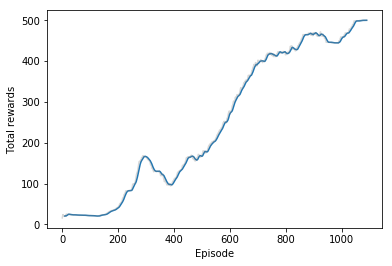

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

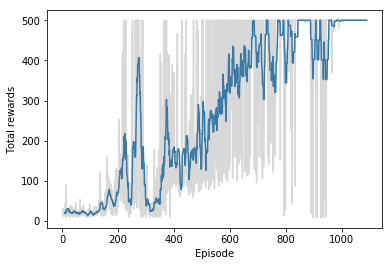

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.